In [1]:
# Import libraries required for EDA
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os
import warnings
import requests
import time
import json

# Import Scikit-learn required libraries
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

# Import function to clear output
from IPython.display import clear_output

# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc, gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 

# Define list of colors for charts
colors_list = list(mcolors.TABLEAU_COLORS.values())

format_json = lambda x: json.dumps(x, indent=4)

# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


In [2]:
def nbins(data, rule):
    """Estimate adequate number of bins for histograms."""
    
    # Get the number of items within the dataset
    data = data[~np.isnan(data)]
    n = len(data)
    
    # Compute the histogram bins size (range)
    bins_width = {'sturge': 1 + 3.322*np.log(n),    
                 'scott': 3.49*np.std(data)*n**(-1/3),                       
                 'rice': 2*n**(1/3),                         
                 'fd': 2*st.iqr(data)*n**(-1/3)}
    
    # Compute number of bins
    n_bins =  math.ceil((data.max() - data.min())/bins_width[rule])
    
    return {'n': n_bins, 'width': bins_width[rule]}

def order_of_magnitude(value):
    """Get order of magnitude"""
    if value==0: return 0
    if abs(value)==np.inf: return np.inf
    
    return (math.floor(math.log(abs(value), 10)))

def print_kde(data, bandwidths, **kwargs):
    
    # plot the histogram and pdf
    plt.figure(figsize = kwargs.get('figsize',(6, 3)) )
    plt.hist(data, bins = kwargs.get('bins', 50), density=True, ec='white', label=r'Actual')
    
    for bw in bandwidths:
        
        # Fit density
        model = KernelDensity(bandwidth=bw, kernel='gaussian')
        data = data.reshape((len(data), 1))
        model.fit(data)

        # sample probabilities for a range of outcomes
        values = np.asarray([value for value in np.linspace(min(data), max(data), 200)])
        values = values.reshape((len(values), 1))
        probabilities = np.exp(model.score_samples(values))
        
        plt.plot(values, probabilities, label=r'Estimated (bw = %.4f)' % bw)

    plt.xlabel(kwargs.get('xlabel', 'Feature'))
    plt.ylabel('Probability density')
    plt.title('Probability Density analysis using Gaussian kernel', fontsize=10)
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc='best', fontsize=10)
    plt.show()

## 2. - Datasets creation

### 2.1. - Trimodal distribution

In [ ]:
# generate a sample
sample1 = np.random.normal(loc=300, scale=5, size=50)
sample2 = np.random.normal(loc=425, scale=6, size=350)
sample3 = np.random.normal(loc=600, scale=6, size=600)
sample  = np.hstack((sample1, sample2, sample3))

# plot the histogram
plt.figure(figsize=(6,3))
plt.hist(sample, bins=50, ec='white')
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.show()

### 2.2. - Kelvin's dataset feature distribution

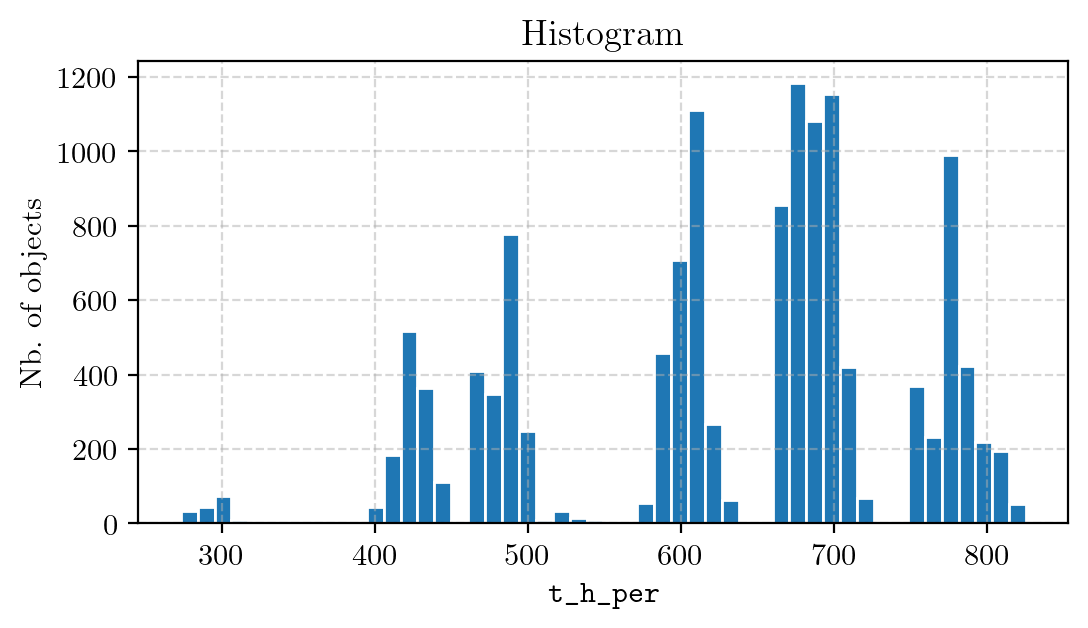

In [3]:
# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
# df.head(10)

# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(6)

data = df_lastCDM['t_h_per'].to_numpy()

plt.figure(figsize=(6,3))
plt.hist(data, bins=50, ec='white')
plt.xlabel(r'\texttt{t_h_per}')
plt.ylabel('Nb. of objects')
plt.title('Histogram')
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.show()


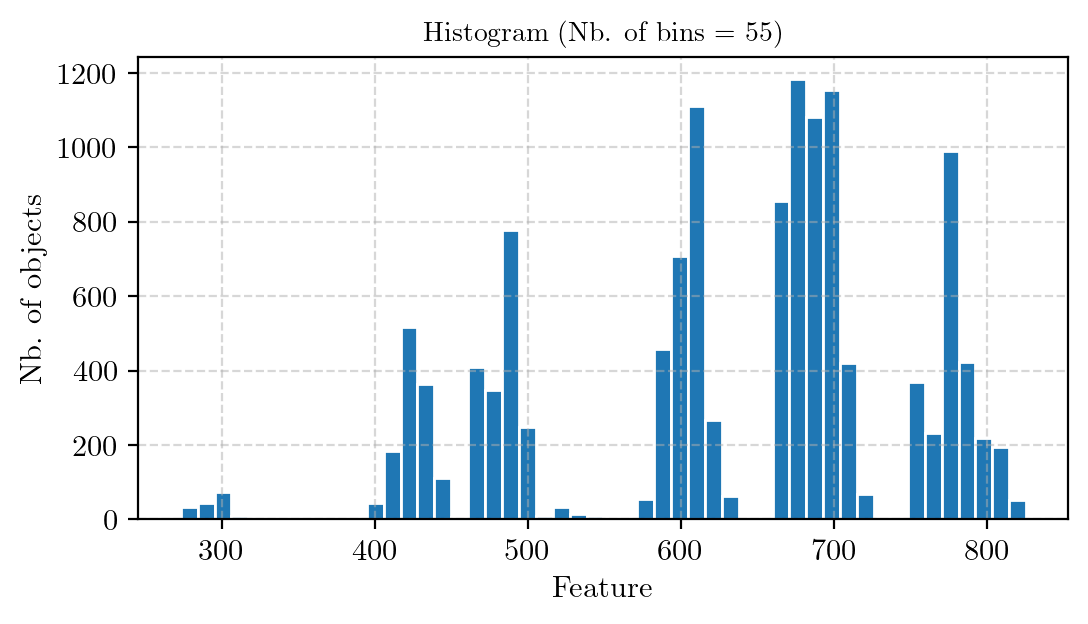

In [5]:
# data = sample
data = df_lastCDM['t_h_per'].to_numpy()

bins = nbins(data, 'fd')

plt.figure(figsize=(6,3))
plt.hist(data, bins=50, ec='white')
plt.xlabel('Feature')
plt.ylabel('Nb. of objects')
plt.title('Histogram (Nb. of bins = %d)' % bins['n'], fontsize=10)
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.show()


## 3. - [Kernel Estimator and Bandwidth Selection for Density and its Derivatives](https://cran.microsoft.com/snapshot/2015-07-29/web/packages/kedd/vignettes/kedd.pdf)

### 3.2.1. - Maximum likelihood cross-validation (MLCV)

[Kernel Estimator and Bandwidth Selection for Density and its Derivatives](https://arxiv.org/pdf/2012.06102.pdf)


$MLCV(b_w) = \left( \frac{1}{n}\cdot\sum_{i=1}^{n}\log \left[ \sum_{j\neq i} K\left( \frac{X_j-X_i}{b_w}\right)\right] - \log\left[(n-1)\cdot b_w\right] \right)$

In [6]:
def mlcv(data, bw, print_log=True):
    """Maximum likelihood cross-validation (MLCV)"""
    
    # Calculate number of data points
    n = len(data)
    
    # Create gaussian kernel function
    kernel = lambda x: 1/(np.sqrt(2*np.pi))*np.exp(-0.5*x**2)

    # Initialize output with the second term of the equation
    output = -np.log((n-1)*bw)
    
    # Iterate over all the values of the data to compute the argument of the first term's logarithm
    for i in range(n):
        
        # Get second dimension of the data
        data_j = [data[j] for j in range(n) if j!=i]
        
        # Compute the argument of the logarithm and add it to the output.
        log_arg = kernel((data_j - data[i])/bw)
        output = output + 1/n*np.log(np.sum(log_arg))
        
    if print_log==True: print('\t - Bandwidth = %.4e \t MLCV = %.4e' % (bw, output))
    
    return output

def argmax_mlcv(data, bwlim, tol=1e-3, max_iter=50, print_log=True):
    """Compute bandwidth that maximizes MLCV"""
    
    # Define initial bandwidths, steps, best bandwidth and number of iterations
    bandwidths, step = np.linspace(bwlim[0], bwlim[1], num=4, endpoint=True, retstep=True)

    best_bw = 0
    max_mlcv = -np.inf
    n_iter = 0
    
    while True and n_iter<max_iter:

        print('\nComputing MLCV for the bandwidths in range: [%.5f, %.5f] (iter = %d)' % 
              (bandwidths[0],bandwidths[-1], n_iter))

        # Compute MLCV for every bandwidth
        mlcv_array = [mlcv(data, bw, (print_log==True or print_log=='full')) for bw in bandwidths]
        
        # Get the maximum local MLCV its corresponding bandwidth bw
        
        print_format = {'mlcv': order_of_magnitude(abs(max_mlcv - max(mlcv_array))),
                       'bw': order_of_magnitude(abs(best_bw - bandwidths[mlcv_array==max(mlcv_array)][0]))}
        # print(print_format)
        
        max_mlcv = max(mlcv_array)
        best_local_bw = bandwidths[mlcv_array==max_mlcv][0]

        # Stop loop if preccision required is met
        precission = abs(best_bw - best_local_bw)
        if print_log!=False:
            print(" -> Best local bandwidth = {:.4e}\n"\
                  "    Max. local MLCV      = {:.4e}\n"\
                  "    Step                 = {:.4e}\n"\
                  "    Precission           = {:.4e}"\
                  .format(best_local_bw, max_mlcv, step, precission))
        
        if precission<=tol: break
            
        # Assign new best local bandwidth and reassign bandwidth limits for another iteration
        best_bw = best_local_bw
            
        # Define new bandwidth array for another iteration
        bwlim = [max(best_bw - step, best_bw*0.5), best_bw + step]
        bandwidths, step = np.linspace(bwlim[0], bwlim[1], num=4, endpoint=True, retstep=True)
            
        n_iter += 1
    
    return best_bw, max_mlcv



In [7]:
bwlim = [0.1, 2.0]
best_bw, max_mlcv = argmax_mlcv(data, bwlim, tol=1e-3, max_iter=50, print_log=True)

print("Best bandwidth = %.4e / Max. MLCV = %.4e" % (best_bw, max_mlcv))

print_kde(data, best_bw)


Computing MLCV for the bandwidths in range: [0.10000, 2.00000] (iter = 0)


/var/folders/m2/1phpry2j5w739bgs4cqbg0pw0000gn/T/ipykernel_26153/201166348.py:21: RuntimeWarning: divide by zero encountered in log
  output = output + 1/n*np.log(np.sum(log_arg))


	 - Bandwidth = 1.0000e-01 	 MLCV = -inf
	 - Bandwidth = 7.3333e-01 	 MLCV = -5.1730e+00
	 - Bandwidth = 1.3667e+00 	 MLCV = -5.2479e+00
	 - Bandwidth = 2.0000e+00 	 MLCV = -5.2988e+00
 -> Best local bandwidth = 7.3333e-01
    Max. local MLCV      = -5.1730e+00
    Step                 = 6.3333e-01
    Precission           = 7.3333e-01

Computing MLCV for the bandwidths in range: [0.36667, 1.36667] (iter = 1)
	 - Bandwidth = 3.6667e-01 	 MLCV = -5.1073e+00
	 - Bandwidth = 7.0000e-01 	 MLCV = -5.1677e+00
	 - Bandwidth = 1.0333e+00 	 MLCV = -5.2137e+00
	 - Bandwidth = 1.3667e+00 	 MLCV = -5.2479e+00
 -> Best local bandwidth = 3.6667e-01
    Max. local MLCV      = -5.1073e+00
    Step                 = 3.3333e-01
    Precission           = 3.6667e-01

Computing MLCV for the bandwidths in range: [0.18333, 0.70000] (iter = 2)
	 - Bandwidth = 1.8333e-01 	 MLCV = -5.1081e+00
	 - Bandwidth = 3.5556e-01 	 MLCV = -5.1054e+00
	 - Bandwidth = 5.2778e-01 	 MLCV = -5.1374e+00
	 - Bandwidth = 7.0000e

KeyboardInterrupt: 

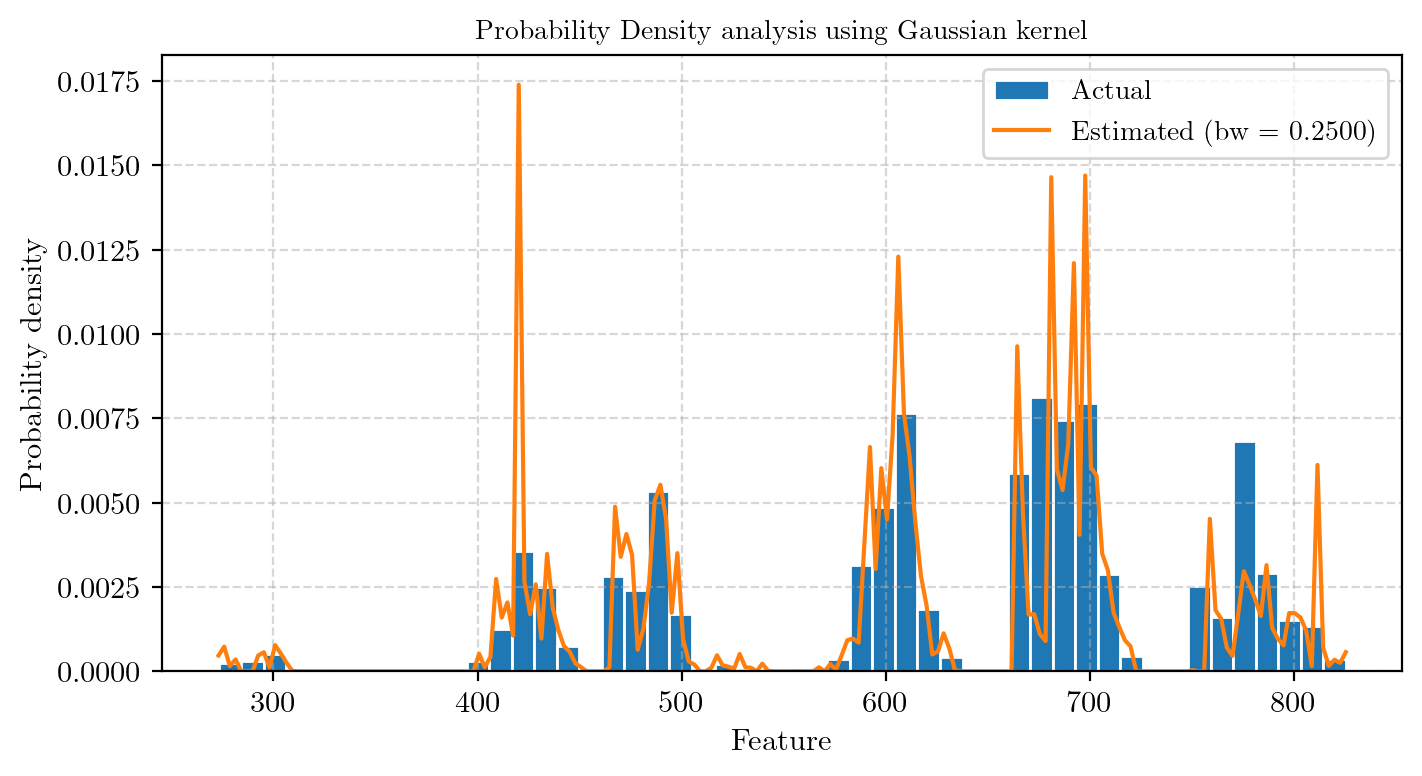

In [10]:
print_kde(data, [0.25], figsize=(8,4))

In [ ]:
import numpy as np
import statsmodels
import statsmodels.api as sm

settings = statsmodels.nonparametric.kernel_density.EstimatorSettings(
    efficient=True,
    n_sub=len(data)//10)


dens_u = sm.nonparametric.KDEMultivariate(data=data,
                                          var_type='c', 
                                          bw='cv_ml',
                                         defaults=settings)
dens_u.bw


In [ ]:
print_kde(data, 0.7877071)

### 3.2.2. - Minimum Squared Error cross-validation (MSECV)

In [11]:
# Define function to compute KDE
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(np.array(x).reshape(-1,1))
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    
    return np.exp(log_pdf)

In [12]:
def plot_mse_bw(bandwidths, mse):
    
    # Plot MSE vs bandwidth
    plt.figure(figsize=(6,3))
    plt.plot(bandwidths, mse, '--')
    plt.plot(bandwidths[mse==mse.min()][0], mse.min(), 'ro', label = f'BW = {best_bw:.4f}')
    plt.xlabel('Bandwidth', fontsize=10)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=10)
    plt.title('Bandwidth selection using MSE cross-validation', fontsize=12)
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    return

In [20]:
# Features to approximate t_h_per, t_j2k_sma, t_j2k_inc, t_j2k_ecc
features = ['t_h_per', 't_j2k_sma', 't_j2k_inc', 't_j2k_ecc', 'azimuth']
feature = features[4]
data = df_lastCDM[feature].to_numpy()

# Shuffle data
np.random.shuffle(data)

sample_sizes  = np.arange(500,5000,500)

tol = 1e-5
max_iter = 100
bins = nbins(data, 'fd')

# Create cluster array to get batches of data
n_samples = np.arange(start=2, stop=11, step=1, dtype=np.int32)
best_bws = np.zeros(len(n_samples))

for i, n_clusters in enumerate(n_samples):
    print(f'Total batches = {n_clusters} ({len(data)//n_clusters} data points per batch)')
    
    clusters = np.random.randint(low=0, high=n_clusters, size=len(data))
    
    # Initialize array to store actual probabilty densities (apds)
    apds = np.zeros((bins['n'], n_clusters))
    
    for j in range(n_clusters):
        sample = data[clusters==j]

        apd, bin_edges = np.histogram(sample, bins = bins['n'], density=True)
        apds[:,j] = apd

    # Compute bin centers to which the density computed shall be linked
    bin_centers = bin_edges[:-1] + bins['width']/2

    # Compute average of all actual probability densities computed
    avg_apd = np.mean(apds, axis=1, dtype=np.float64)

    # Initialize bandwidth and MSE arrays
    bandwidths, step = np.linspace(bins['width']/100, bins['width'], 100, retstep=True)

    best_bw = np.inf
    while True:

        mse = np.zeros(len(bandwidths))

        for b, bandwidth in enumerate(bandwidths):

            epd = kde_sklearn(data, bin_centers, kernel='gaussian', bandwidth=bandwidth)
            mse[b] = ((epd - avg_apd)**2).mean()

        
        bw = bandwidths[mse==mse.min()][0]

        # print(f'  New bandwidth: {bw:.4e} MSE: {mse.min():.5e}')
        if abs(1 - best_bw/bw) <= tol: break 

        bandwidths, step = np.linspace(bw-step, bw+step, 100, retstep = True)
        best_bw = bw

    best_bws[i] = best_bw 

    print(f'Best bandwidth = {best_bw:.5f} \nMSE = {mse.min():.4e}\n')

scale = 10**order_of_magnitude(best_bws.mean())
best_bw = (math.ceil(best_bws.mean()/scale)*scale)

print(f'Final Optimal bandwidth = {best_bw}')



Total batches = 2 (6577 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.0444e-06

Total batches = 3 (4384 data points per batch)
Best bandwidth = 6.40965 
MSE = 4.6517e-07

Total batches = 4 (3288 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.2535e-06

Total batches = 5 (2630 data points per batch)
Best bandwidth = 5.72295 
MSE = 7.1641e-07

Total batches = 6 (2192 data points per batch)
Best bandwidth = 6.48836 
MSE = 4.9850e-07

Total batches = 7 (1879 data points per batch)
Best bandwidth = 6.48836 
MSE = 1.4520e-06

Total batches = 8 (1644 data points per batch)
Best bandwidth = 6.48836 
MSE = 9.3921e-07

Total batches = 9 (1461 data points per batch)
Best bandwidth = 6.48836 
MSE = 8.6891e-07

Total batches = 10 (1315 data points per batch)
Best bandwidth = 4.70856 
MSE = 7.6367e-07

Final Optimal bandwidth = 7


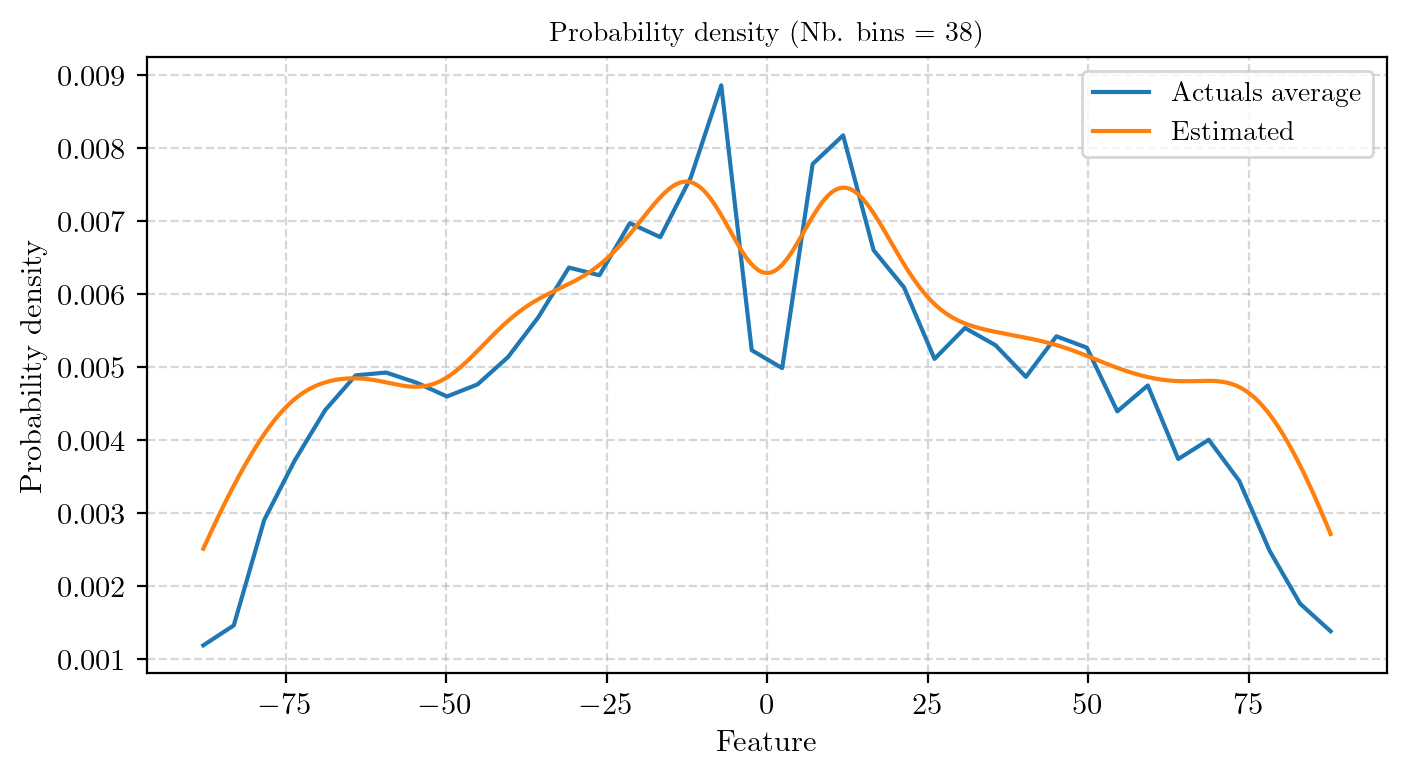

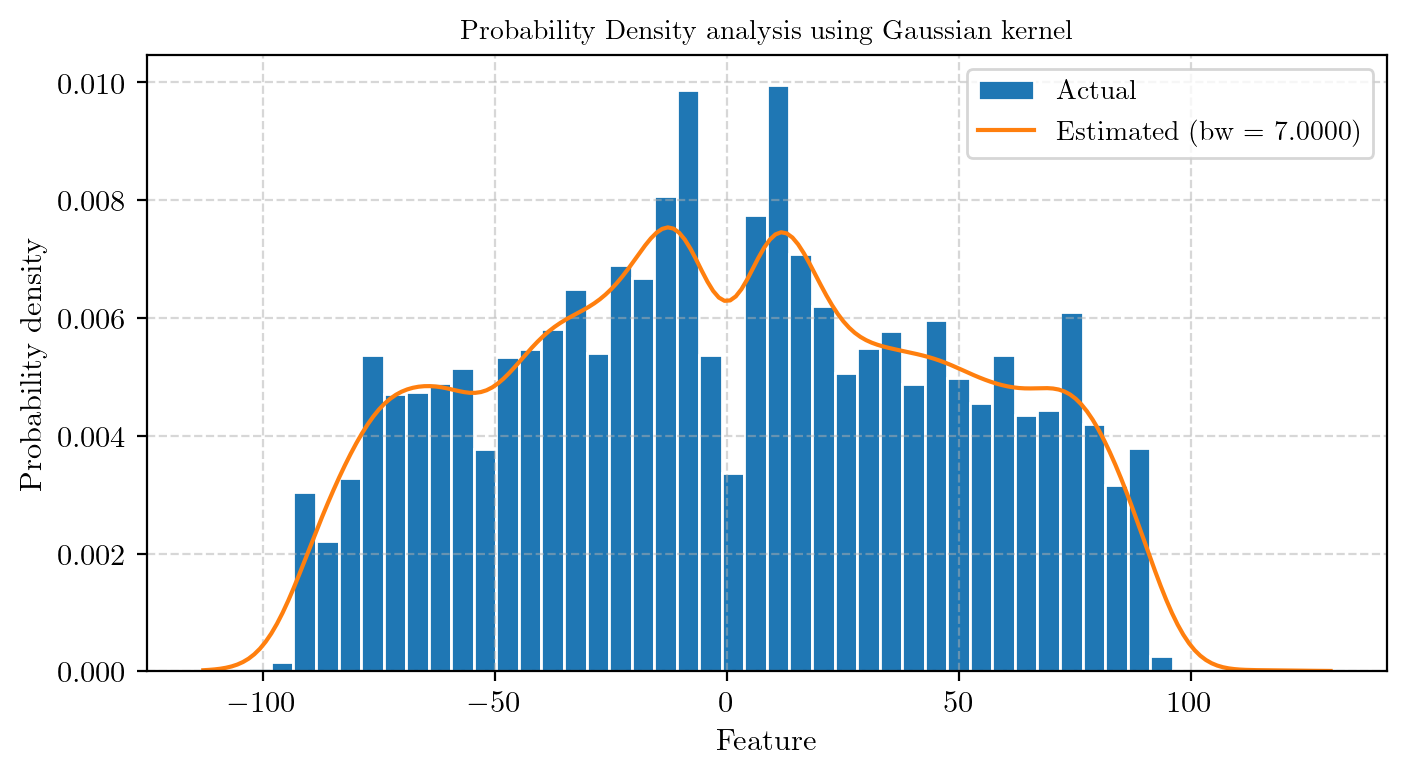

In [21]:
# Scale best_bw to 1.75

kde_x_grid = np.linspace(bin_centers[0], bin_centers[-1],1000)
epd = kde_sklearn(data, kde_x_grid, kernel='gaussian', bandwidth=best_bw)

plt.figure(figsize=(8,4))
plt.plot(bin_centers, avg_apd, label = r'Actuals average')
plt.plot(kde_x_grid, epd, label = r'Estimated')
plt.xlabel('Feature')
plt.ylabel('Probability density')
plt.title('Probability density (Nb. bins = %d)' % bins['n'], fontsize=10)
plt.grid(True, linestyle="dashed", alpha=0.5)
plt.legend(loc='best', fontsize=10)
plt.show()

print_kde(data, [best_bw], figsize=(8,4))